## PRiAD 4

# Uczenie nienadzorowane

Tematem ćwiczenia jest uczenie nienadzorowane, nawywane też uczeniem bez nauczyciela. W ćwiczeniu pokazane zostaną dwie metody grupowania: aglomeracyjne grupowanie hierarchiczne oraz metoda k-średnich. Ponadto przedmiotem ćwiczenia będzie metoda a-priori analizy podobieństw (analizy koszyka zakupowego).

Implementacje algorytmów grupowania danych można znaleźć w pakietach `scipy`, który jest rozbudowaną [biblioteką wykorzystywaną w obliczenia naukowych](https://www.scipy.org) oraz `scikit-learn` - [bibliotece uczenia maszynowego](https://scikit-learn.org). Na potrzeby grupowania będą z niej importowane jedynie niezbędne procedury. Na potrzeby analizy koszyka zakupowego zaimportowane zostaną metody z bibliteki `mlxtend`. 

Tradycyjnie pracę rozpoczniemy od importu niezbędnych pakietów.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# import niezbędnych procedur pakietu scipy i scikit.learn
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# pakiet mlxtend wymaga wcześniejszej instalacji
# w razie problemów z instalacją przez anaconda navigator-a
# należy w Anaconda prompt wpisać:
# pip install mlxtend   
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format 

## 1. Hierarchiczne grupowanie aglomeracyjne


Grupowanie danych jest najważniejszym członkiem rodziny metod uczenia nienadzorowanego. Polega ono na podziale zbioru danych na klasy, przy wykorzystaniu podobieństwa cech między poszczególnymi obiektami. Podobieństwo to określane jest przy pomocy różnych metryk np. Euklidesowej lub miejskiej.

**Grupowanie hierarchiczne** polega na iteracyjnym łączeniu w grupy (klastry) obiektów najbardziej do siebie podobnych przy pomocy przyjętej metryki. Struktura połączeń grup jest odwzorowywana w drzewie połączeń - dendrogramie. Wyróżnia się dwa podejścia do budowania hierachii grup:
1. Aglomeracyjne - polegająca na budowaniu drzewa od liści do korzenia. Początkowo każdy obiekt stanowi odrębną grupę. Następnie następuje łączenie grup. W każdej iteracji dwie najbliższe grupy są łączone w jedną, większą. 
2. Rozdzielające - polegająca na na budowaniu drzewa od korzenia do liści. Najpierw wszystkie próbki uważane są za jedną grupę, po czym jest ona dzielnona na mniejsze grupy, aż do otrzymania liczby grup równej liczbie obiektów.

W ćwiczeniu będzie pokazana metoda aglomeracyjna.

Przykład poniżej pokazuje wyniki grupowania aglomeracyjnego dla zbioru `dane1`. Kolejne wykresy pokazują dane oryginalne na wykresie punktowym, dane oryginalne bez uwzględniania atrybutu decyzyjnego (wykres punktowy), dendrogram oraz wynik grupowania na wykresie punktowym. W przykładzie liczba grup jest wyznaczana automatycznie jako procent (zmienna `prog_proc`) największej odległości między grupami przypisanej do węzła dendrogramu (korzenia drzewa). 

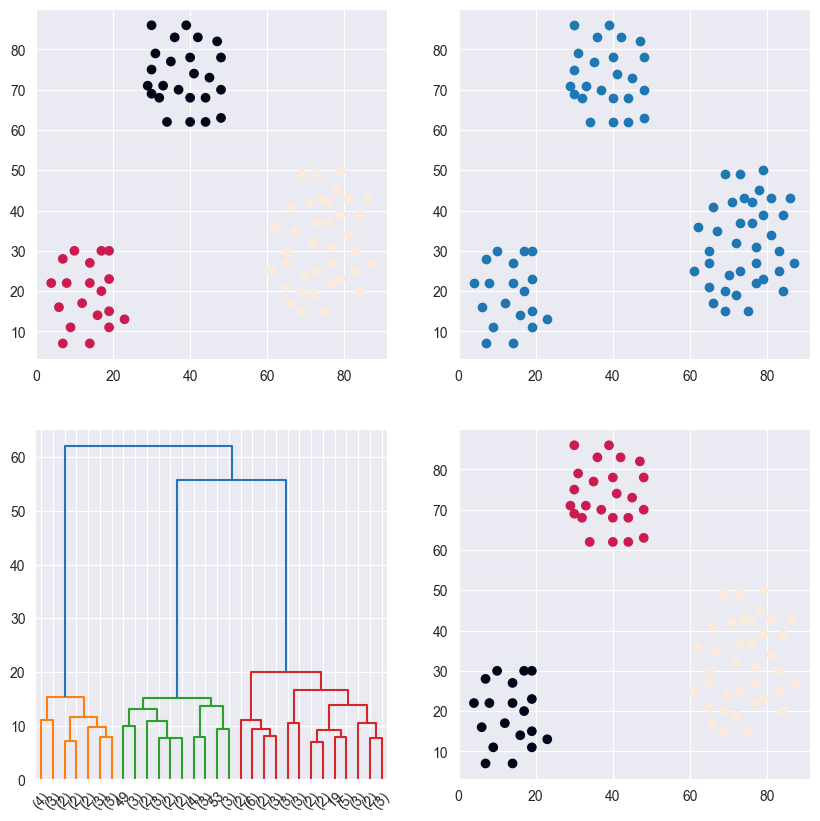

In [3]:
df_org = pd.read_csv('sources/dane1.csv')
# nowa ramka bez kolumny z informacją o klasie
df = df_org.drop(columns = ['klasa'])
grupy = linkage(df, method = 'average', metric = 'euclidean')
prog_proc = 70
prog = prog_proc*max(grupy[:,2])/100
# zamiast linkage(df, method='ward', metric='euclidean') można napisać ward(df)


plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.scatter(x = df['atrybut1'], y = df['atrybut2'], c = df_org['klasa'].astype('category').cat.codes)
plt.subplot(2,2,2)
plt.scatter(x = df_org['atrybut1'], y = df_org['atrybut2'])
plt.subplot(2,2,3)
cl = dendrogram(grupy, truncate_mode = 'lastp', color_threshold = prog )
df['grupa'] =  fcluster(grupy, prog, criterion = 'distance')
plt.subplot(2,2,4)
plt.scatter(x = df['atrybut1'], y = df['atrybut2'], c = df['grupa'])

> **Zadanie** Czy wynik grupowania jest zgodny z przypisaniem punktów do klas w zbiorze oryginalnym ? Zbadaj pozostałe zbiory `dane2`,...`dane11`. Czy wyniki oryginalnego przypisania do klas i grupowania zawsze są zgodne ? Z czego wynikają różnice ? O czym świadczą ?

W przykładzie powyżej liczba grup jest wyznaczana automatycznie. Alternatywą jest ręczne wyznaczenie liczby grup na podstawie wiedzy zewnętrznej o zbiorze danych (jeśli takowa jest dostępna), lub na podstawie obserwacji dendrogramu.  

Istotnym parametrem metody jest sposób wyznaczania odległości międzygrupowej ("linkage")
* average - wykorzystuje średnią odległość między wszystkimi obserwacjami w obu grupach
* complete - wykorzystuje maksymalną odległość między wszystkimi obserwacjami obu grup
* single - wykorzystuje minimalną odległość między wszystkimi obserwacjami obu grup
* ward - minimalizuje wariancję między łączonymi grupami (łączone są te dwie grupy, dla których wariancja po połączeniu będzie najmniejsza) 

Przykład poniżej pokazuje warianty grupowania dla różnych ustalonych liczb grup i dla różnych metod wyznacznia odległości międzygrupowej.

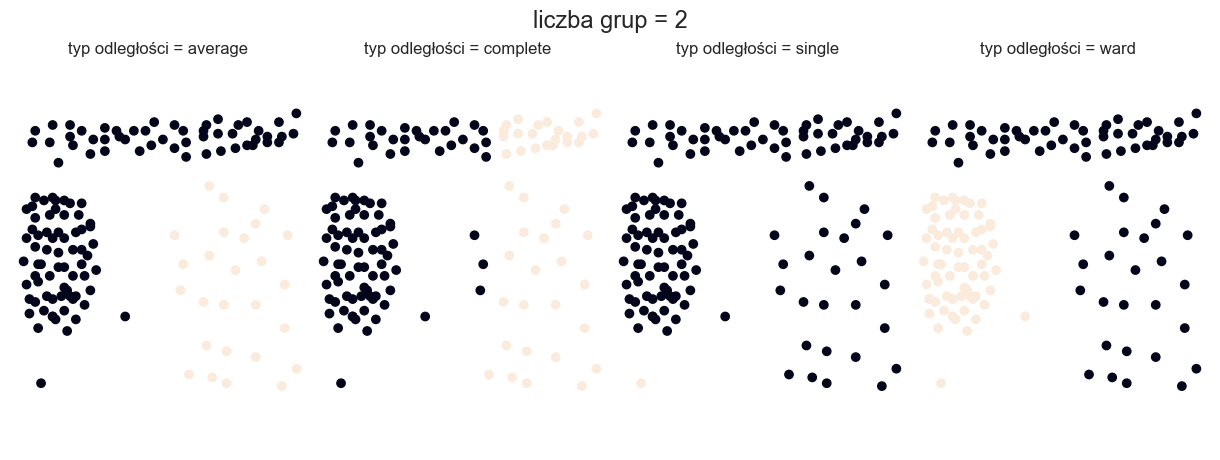

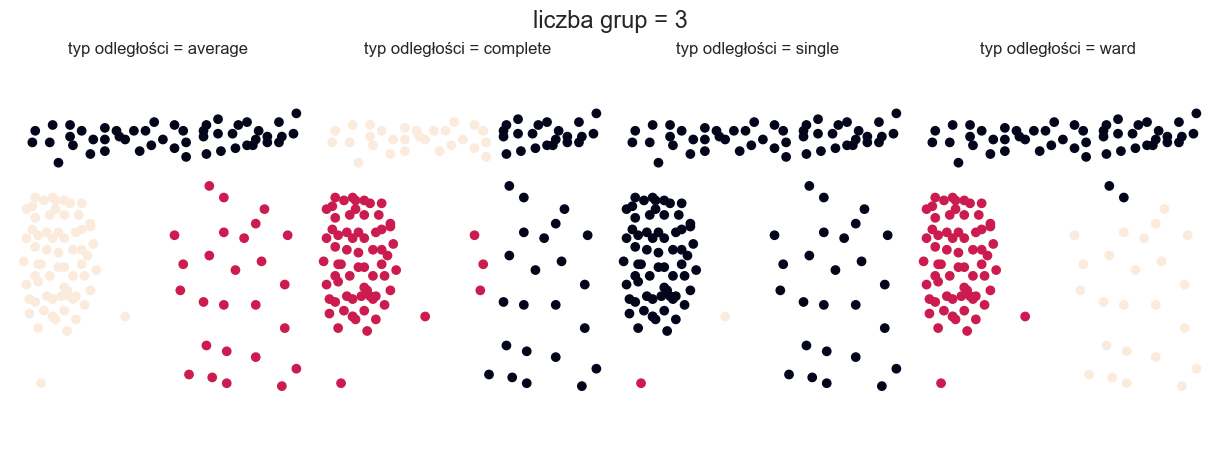

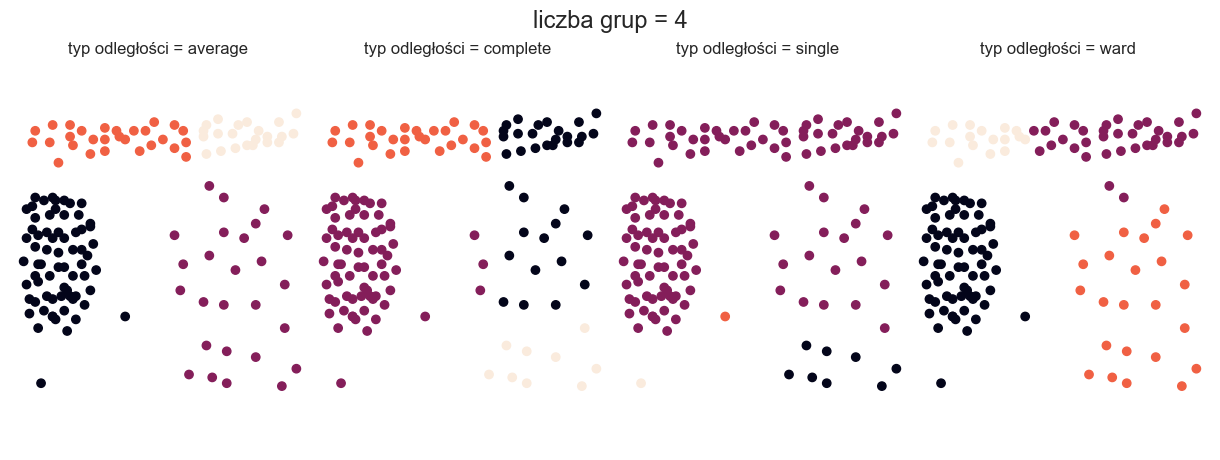

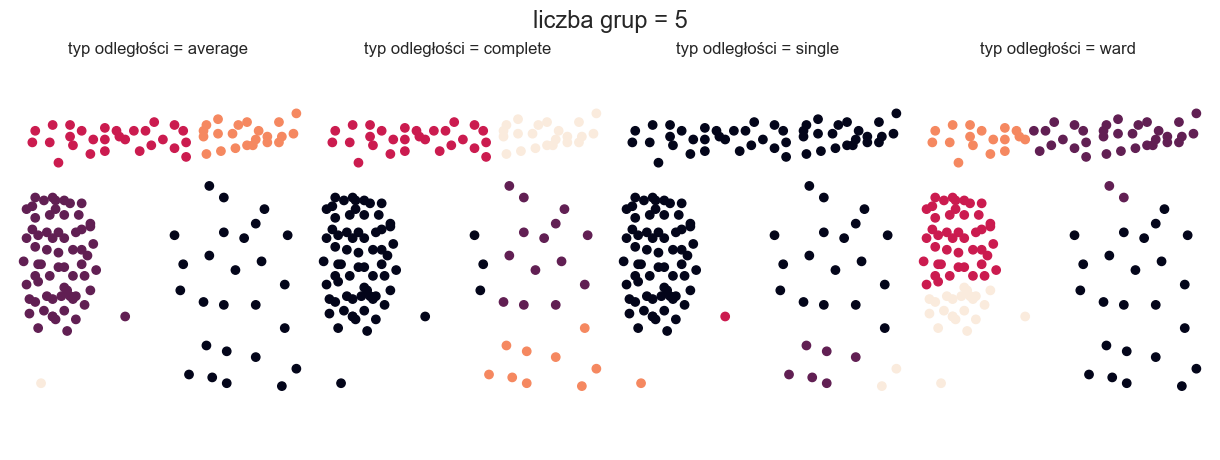

In [5]:
df_org = pd.read_csv('sources/dane6.csv')
# nowa ramka bez kolumny z informacją o klasie
df = df_org.drop(columns = ['klasa'])
for ile_grup in (2,3,4,5):
    plt.figure(figsize=(12, 4.5))
    for index, typ_odleglosci in enumerate(('average', 'complete', 'single', 'ward')):
        plt.subplot(1, 4, index + 1)
        model = AgglomerativeClustering(linkage = typ_odleglosci, n_clusters = ile_grup)
        model.fit(df)
        plt.scatter(df.atrybut1, df.atrybut2, c = model.labels_)
        plt.title('typ odległości = %s ' % typ_odleglosci, fontdict=dict(verticalalignment = 'top'))
        plt.axis('equal')
        plt.axis('off')
        plt.subplots_adjust(bottom = 0, top = .89, wspace = 0, left = 0, right = 1)
        plt.suptitle('liczba grup = %i' % ile_grup, size = 17)

W sytuacji gdy każdemu obiektowi w zbiorze jest przypisana pewna klasa, grupowanie danych może służyć do zbadania czy klasy przypisane arbitralnie obiektom są zgodne z naturalnym przyporzadkowanie obiektów do pewnych grup. Naturalne przyporządkowanie obiektów do grup uzyskujemy przy tym w wybiku grupowania. 

Różnicę między naturalnym przyporządkowanie obiektw a klasami można przedstawić w postaci macierzy pomyłek, która pokazuje jak wygląda przyporządkowanie obiektów w poszczególnych klasach konkretnym grupom. W idealnym przypadku macierz taka powinna w kazdym wierszu (kolumnie) zwierać dokładnie jeden element niezerowy. Macierz pomyłek można przedstawić graficznie w postaci mapy ciepła. 

In [7]:
ile_grup = 3
df_org = pd.read_csv('sources/dane2.csv')
df = df_org.drop(columns = ['klasa'])

model = AgglomerativeClustering(linkage = 'complete', affinity = 'euclidean', n_clusters = ile_grup)
model.fit(df)

klasa = df_org['klasa'].astype('category').cat.codes
grupa = model.labels_

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(x = df_org['atrybut1'], y = df_org['atrybut2'], c = klasa)
plt.title('dane oryginalne')
plt.subplot(1,3,2)
df['grupa'] = model.labels_
plt.scatter(x = df['atrybut1'], y = df['atrybut2'], c = grupa)
plt.title('wynik grupowania')
plt.subplot(1,3,3)
pomylki = pd.crosstab(df_org['klasa'],df['grupa'])
print(pomylki)
sns.heatmap(pomylki,annot = pomylki)
plt.title('macierz pomyłek')

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

> **Zadanie** Sprawdź jak wygląda macierz pomyłek dla pozostałych zbiorów testowych ? Jak mógłbyś ją zinterpretować w każdym przypadku ?

## 2. Grupowanie k-średnich

Metoda **k-średnich** polega na minimalizacji odległości wektorów wartości atrybutów obiektów należących do danego klastra do pewnego punktu charakterystycznego klastra (zwanego jego środkiem lub centroidem), do którego obiekty zostały przyporządkowane. Przyporządkowanie danego obiektu do klastra odbywa się poprzez porównanie jego odległości do wszystkich centroidów. Metoda ta wymaga informacji o liczbie klastrów (grup). Początkowe ich położenia wybierane są losowo albo z użyciem specjalnego algorytmu.  

Algorytm grupowania k-średnich znajduje się w pakiecie `scikit-learn`

/home/marcin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self.tol = tol
/home/marcin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self.tol = tol


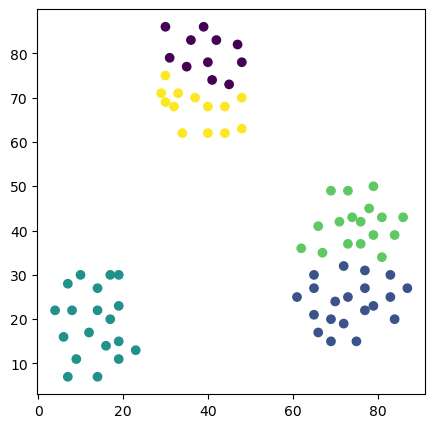

In [7]:
k = 5
df_org = pd.read_csv('dane1.csv')
df = df_org.drop(columns = ['klasa'])

kmeans = KMeans(n_clusters = k, random_state = 0)
kmeans.fit(df)
etykiety_grup = kmeans.fit_predict(df)
plt.figure(figsize = (5,5))
plt.scatter(df.atrybut1, df.atrybut2, marker = 'o', c = etykiety_grup)

W efekcie działania algorytmu otrzymaliśmy wynik grupowania oraz ostateczne wartości centroidów grup. Ich współrzędne możemy otrzymać przy pomocy metody `cluster_centers`.

Współrzędne centroidów: 
 [[39.45454545 79.90909091]
 [73.45       23.75      ]
 [13.36842105 19.21052632]
 [75.         41.41176471]
 [37.61538462 67.61538462]]


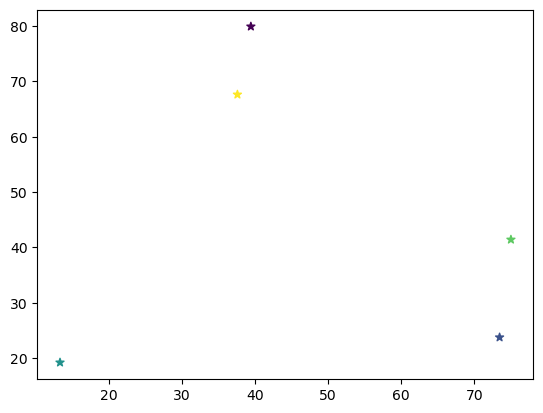

In [8]:
centroidy = kmeans.cluster_centers_
print ("Współrzędne centroidów: \n", centroidy)
plt.scatter(centroidy[:,0], centroidy[:,1], marker = '*', c = np.array(range(k)))

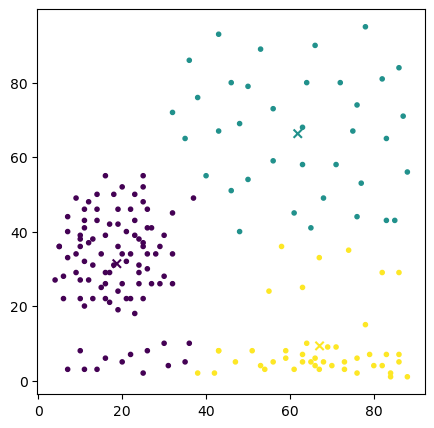

In [10]:
k = 3
df_org = pd.read_csv('dane5.csv')
df = df_org.drop(columns = ['klasa'])

kmeans = KMeans(n_clusters = k, random_state = 0, n_init='auto')
kmeans.fit(df)
etykiety_klastrow = kmeans.fit_predict(df)
plt.figure(figsize = (5,5))
plt.scatter(df.atrybut1, df.atrybut2, marker = '.', c = etykiety_klastrow)
centroidy = kmeans.cluster_centers_
plt.scatter(centroidy[:,0], centroidy[:,1], marker = 'x', c = np.array(range(k)))

> **Zadanie** Wykonaj grupowanie dla innej wartości `random_state` (inna wartość początkowych klastra). Proszę porównać otrzymany wykres z wcześniejszym wynikiem. Skąd wzięła się niestabilność algorytmu polegająca na istnieniu różnic w przyporządkowaniu obiektów do grup ?

> **Zadanie** Przetestuj metodę dla różnych wartości k oraz różnych zbiorów testowych.

Oprócz braku stabilności, ważnym zagadnieniem związanym z algorytmem k-średnich jest dobór liczby klastrów. Z reguły nie jest ona znana, a algorytm wymaga jej do działania. Jeden ze sposobów wyznaczania optymalnej liczby k jest tzw. **metoda łokciowa**, polegająca na iteracyjnym grupowaniu zbioru z rosnącą liczbą klastrów. Następnie wyświetlamy wykres sumy odległości punktów od środków centroidów w funkcji liczby klastrów. Wykres takiej funkcji będzie z początku bardzo szybko maleć by później zmniejszyć swój spadek i spokojnie dążyć do 0 (które osiągnie dla liczby klastrów równej liczbie obiektów w macierzy danych). Punkt w którym obserwowane jest zahamowanie spadku nazywamy punktem łokciowym, który określa optymalną ilość grup. 

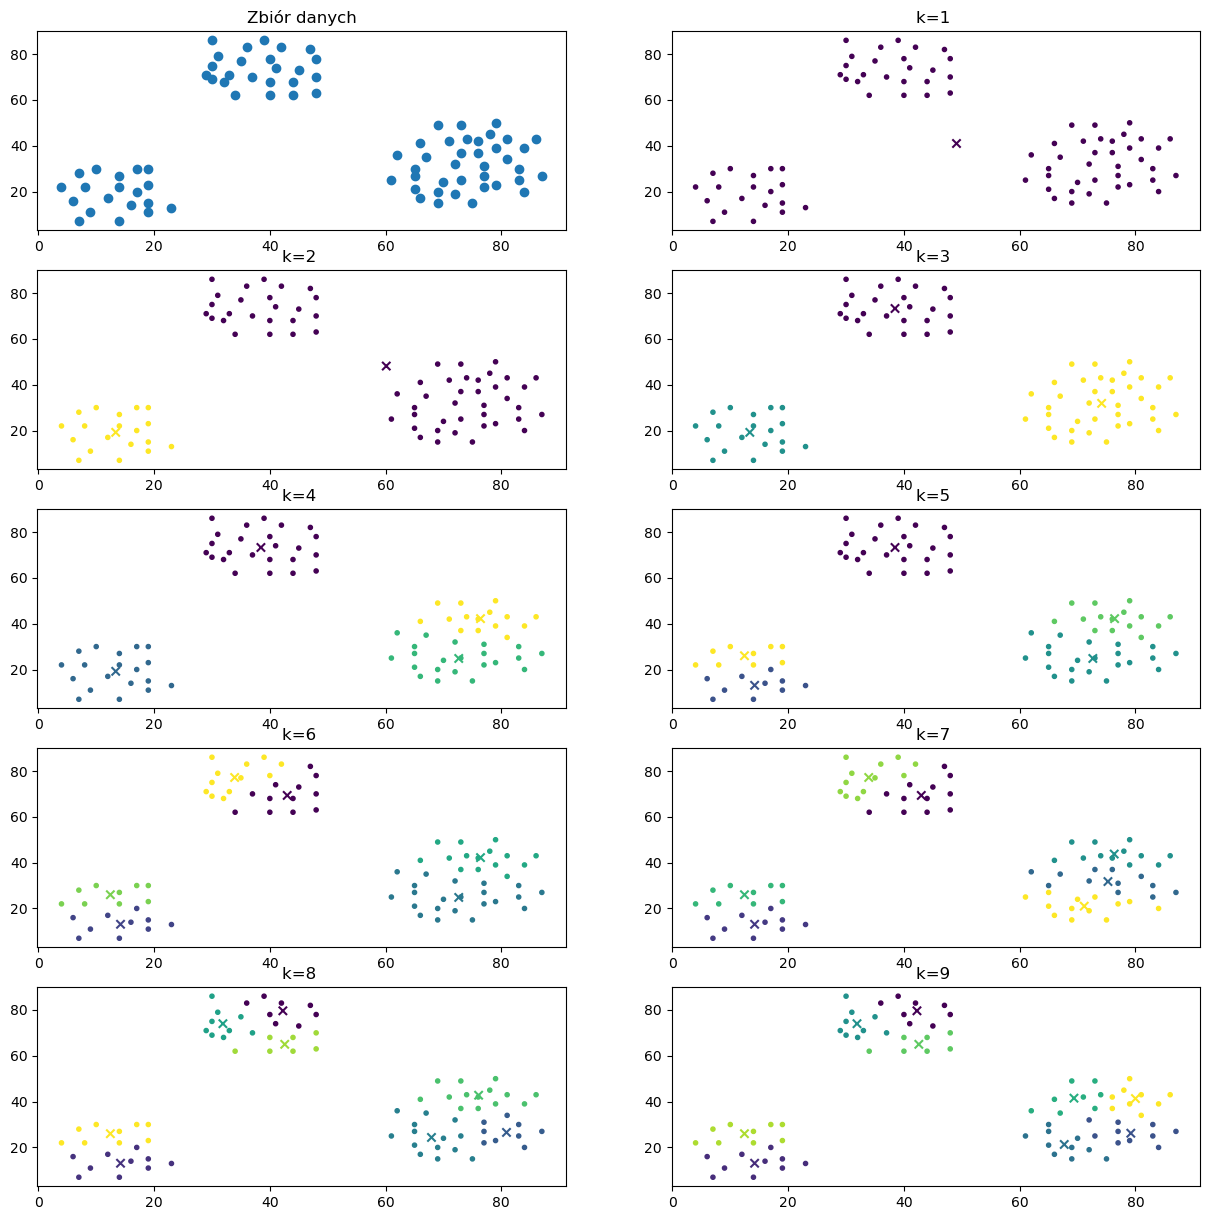

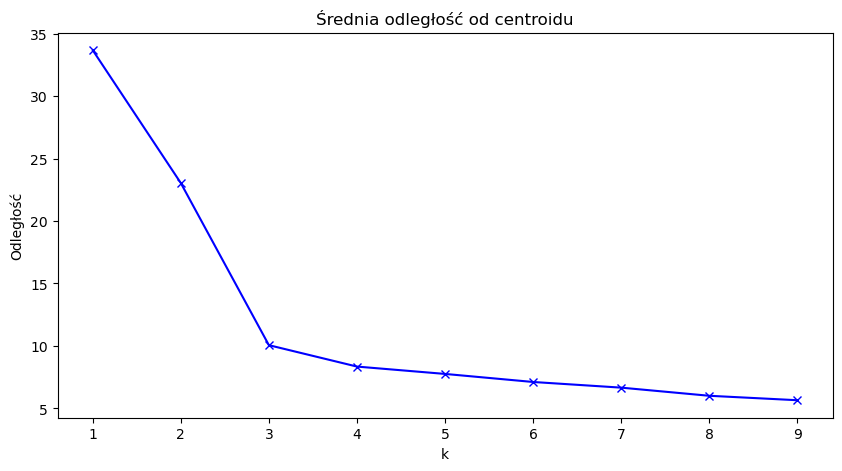

In [12]:
df_org = pd.read_csv('dane1.csv')
df = df_org.drop(columns = ['klasa'])

maks_k = 9
zakres_k = range(1,maks_k)
ile_w_pionie = int(maks_k/2) + 1
plt.figure(figsize=(15,15))
plt.subplot(ile_w_pionie,2,1)
plt.scatter(df['atrybut1'], df['atrybut2'])
plt.title('Zbiór danych')
srednia_odl = []
pozycja = 2
for k in range(1,maks_k+1):
    plt.subplot(ile_w_pionie,2,pozycja)
    pozycja = pozycja + 1
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(df)
    etykiety_klastrow = kmeans.fit_predict(df)
    plt.scatter(df.atrybut1, df.atrybut2, marker='.', c=etykiety_klastrow)
    centroidy = kmeans.cluster_centers_
    plt.scatter(centroidy[:,0], centroidy[:,1], marker='x', c=np.array(range(k)))
    plt.title('k=%s ' % k)
    srednia_odl.append(sum(np.min(cdist(df, centroidy, 'euclidean'), axis=1)) / df.shape[0]) 

plt.figure(figsize=(10,5))
plt.plot(range(1,maks_k+1), srednia_odl, 'bx-')
plt.xlabel('k')
plt.ylabel('Odległość')
plt.title('Średnia odległość od centroidu')
plt.show()

Inna metoda to tzw. **metoda sylwetki (data silhouette)** - wykorzystująca tzw. sylwetkę danych jako miarę dopasowania obiektu do własnego klastra i do klastrów sąsiednich. Miarą sylwetki dla danej obserwacji $s(i)$ nazywamy $s(i)=\frac{b(i)-a(i)}{max\{a(i),b(i)\}}$, gdzie $b(i)$ jest odległością do centroidu najbliżeszgo klastra do którego nie została zaklasyfikowana, a $a(i)$ jest odległością od centroidu do którego została zaklasyfikowana. Liczba grup jest dobierana tak, by wartość średnia miary sylwetki była jak największa tj. jak najwięcej obiektów leżało jak najbliżej własciwych im centroidów. Miara sylwetki dla każdego punktu przyjmuje wartości między -1 a 1.

   atrybut1  atrybut2  etykieta
0     -6.92    -10.67         2
1     -8.63     -7.14         2
2     -9.63     -2.72         1
3     -2.31      5.31         0
4     -7.57     -3.01         3


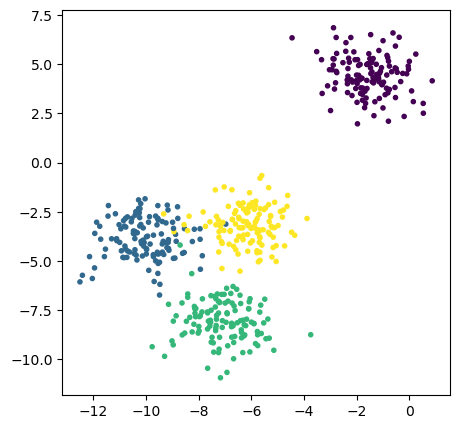

In [13]:
# generujemy nowy zbiór danych 
X1, y1 = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, 
                    center_box = (-10.0, 10.0), shuffle = True, random_state = 1)  
# dwa ostatnie argumenty: przetasowanie kolejności próbek i 
#                  ustawienie momentu startu zmiennej pseudolosowej w celu zapewnienia powtarzalności wyników

# Konwersja zbioru zmiennych opisujących X1 i odpowiadających im klas y1 do jednej macierzy danych (pd.DataFrame)
columns = ['atrybut' + str(x) for x in np.arange(1, X1.shape[1]+1, 1)]
d = {key: values for key, values in zip(columns, X1.T)}
d['etykieta'] = y1
dane1 = pd.DataFrame(d).reindex(columns=columns+['etykieta'])

# Wyświelenie
print(dane1.head())
plt.figure(figsize=(5,5))
plt.scatter(dane1.atrybut1, dane1.atrybut2, marker='.', c=dane1.etykieta)

Badanie wyników grupowania z wykorzystaniem miar sylwetek

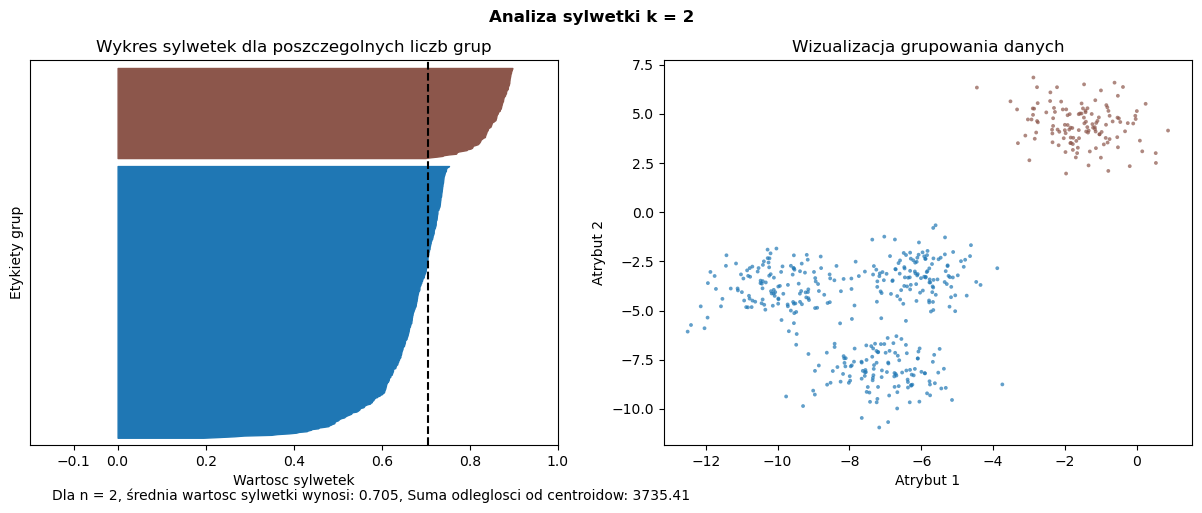

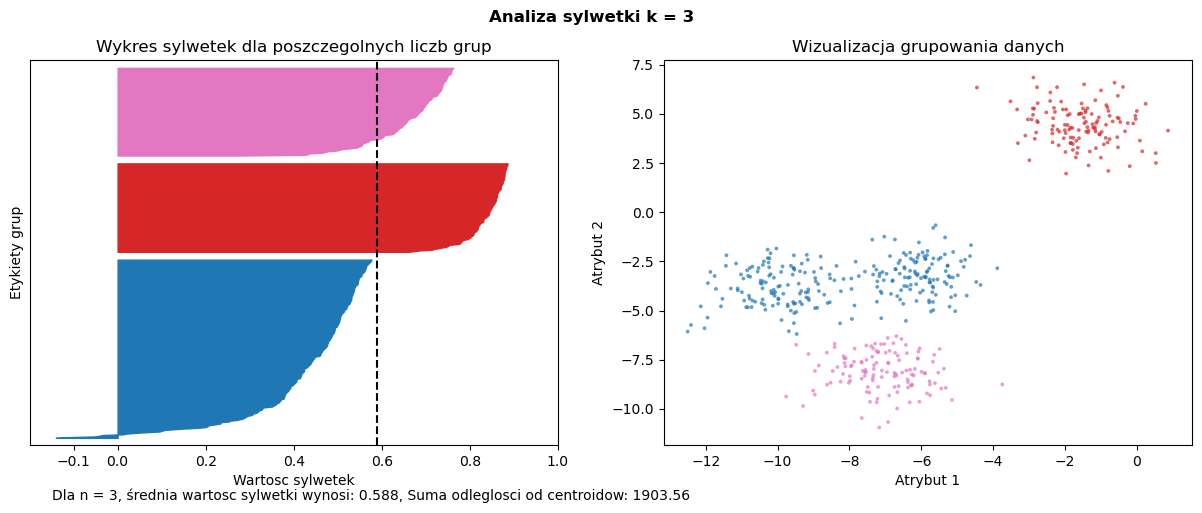

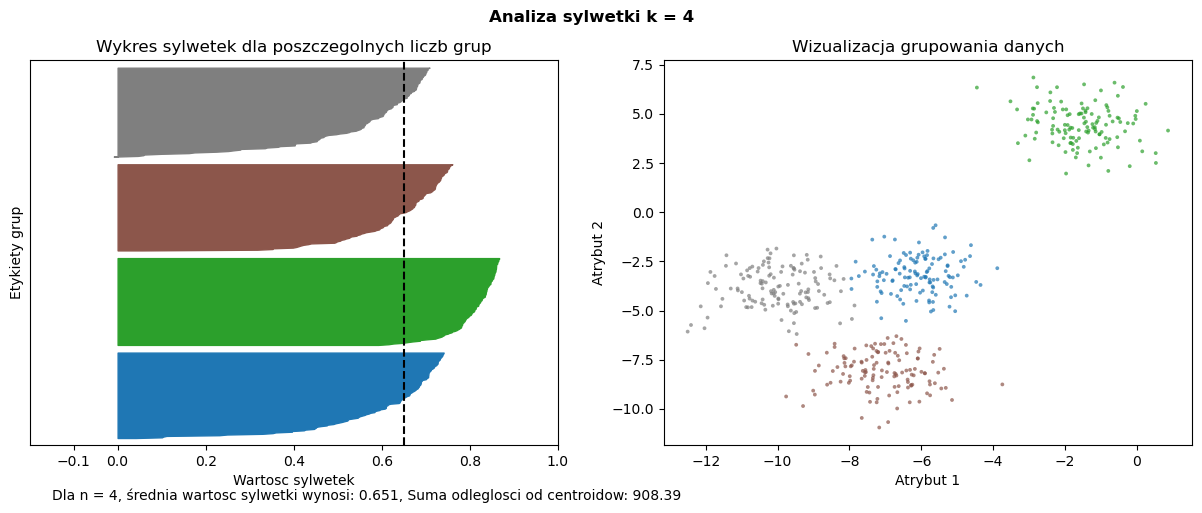

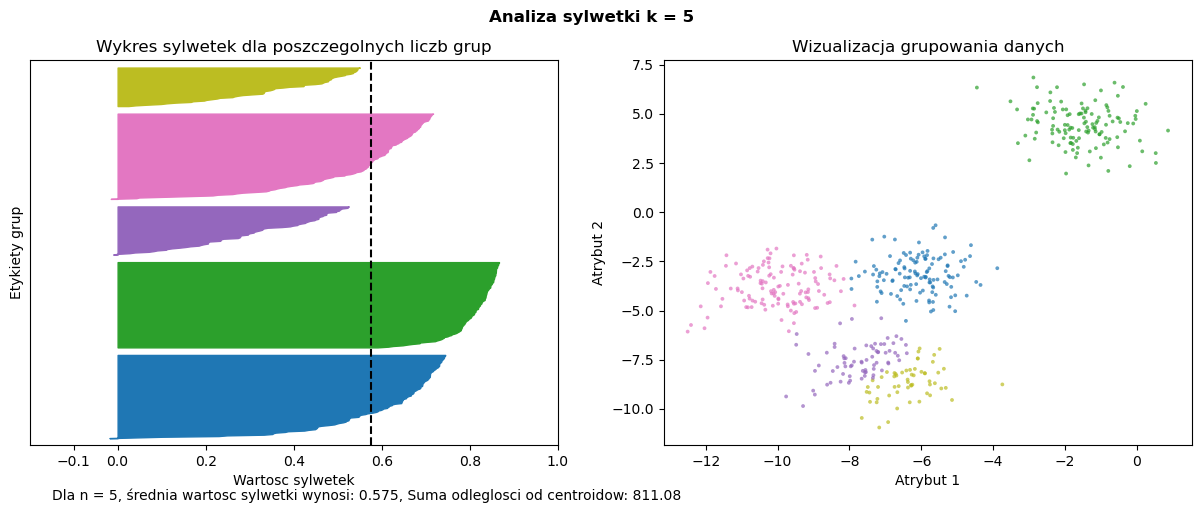

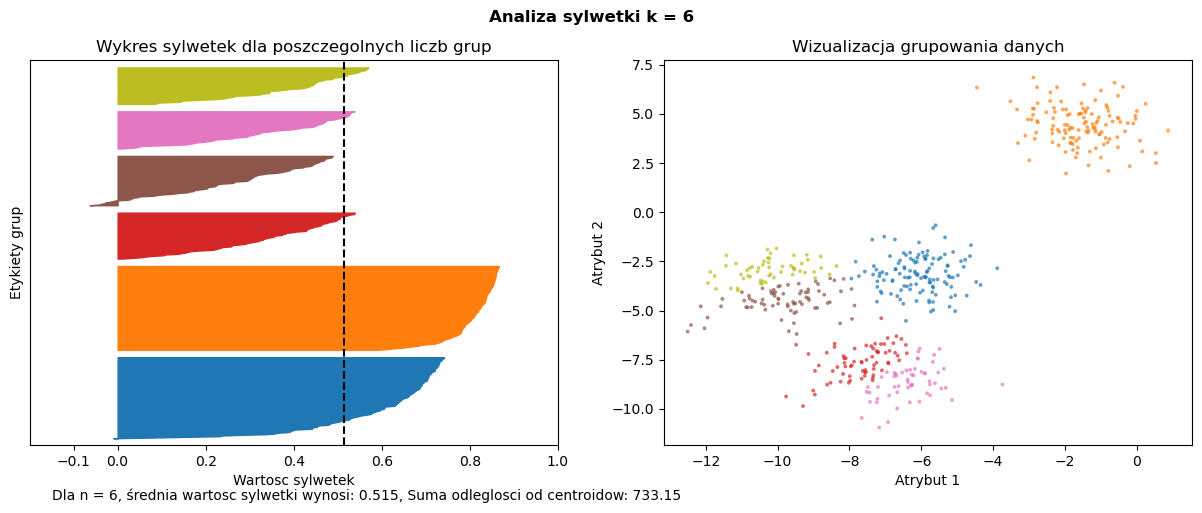

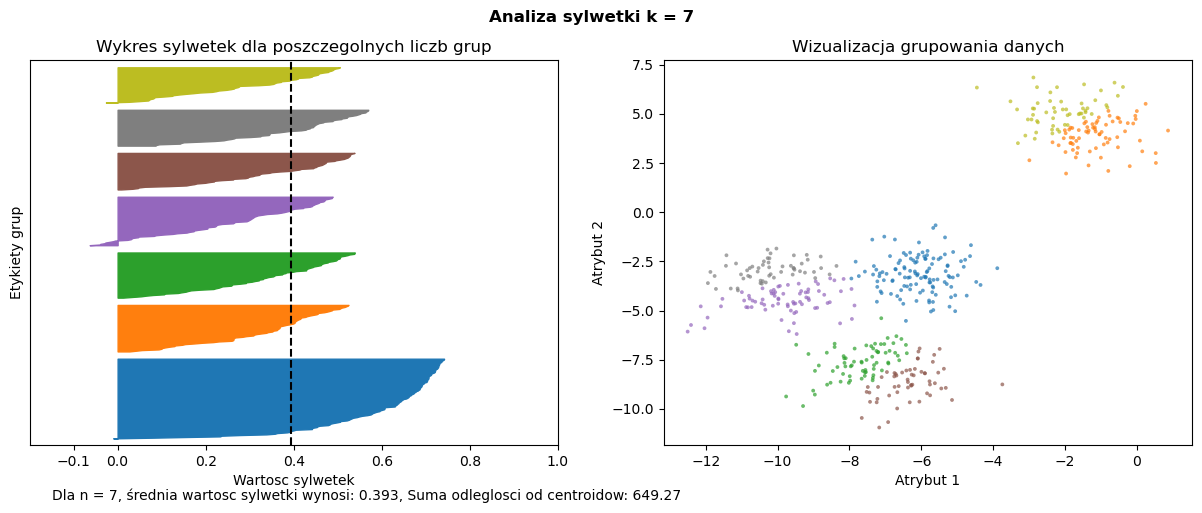

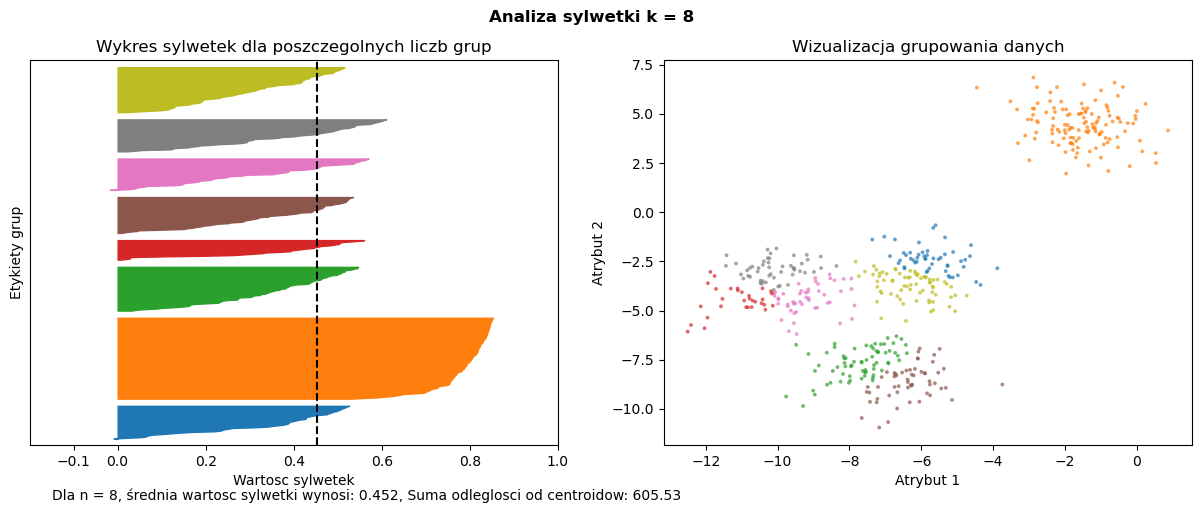

Text(0, 0.5, 'Suma odleglosci od centroidow')

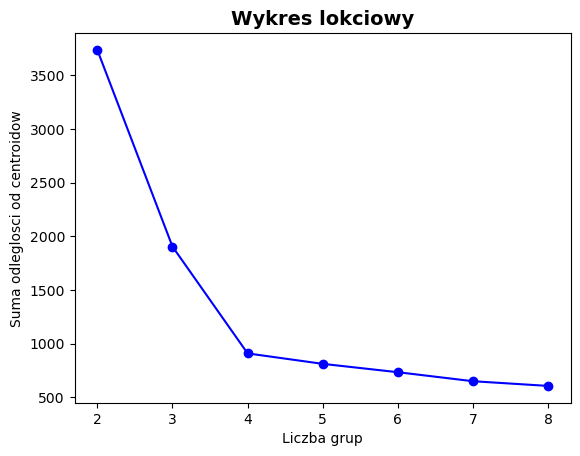

In [19]:
liczby_grup = [2, 3, 4, 5, 6, 7, 8]
miara_jakosci = pd.Series(dtype=float)

for ile_grup in liczby_grup :
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.2, 1]) # zakres zmian współczynnika sylwetki
    ax1.set_ylim([0, len(dane1) + (ile_grup + 1) * 10]) # organizacja wydruku
    
    kmeans = KMeans(n_clusters = ile_grup, random_state = 0, n_init='auto').fit(X1)
  #  miara_jakosci = miara_jakosci.append(pd.Series(kmeans.inertia_))
    miara_jakosci = pd.concat([miara_jakosci,pd.Series(kmeans.inertia_)])
    etykiety_grup = kmeans.fit_predict(dane1[['atrybut1','atrybut2']])
 
    # oblicza miary sylwetek dla każdek grupy
    sylwetka = silhouette_samples(dane1[['atrybut1','atrybut2']], etykiety_grup)   
    # średnia wartość sylwetki
    srednia_sylwetka = silhouette_score(dane1[['atrybut1','atrybut2']], etykiety_grup)
    
    pozycja_kreski = 10
    for i in range(ile_grup):
        # Zebranie wyników sylwetek do próbek należących do klastra i ich sortowanie
        sylwetka_w_grupie = sylwetka[etykiety_grup == i]
        sylwetka_w_grupie.sort()

        liczebnosc_grupy = sylwetka_w_grupie.shape[0]
        kolor = cm.tab10(float(i) / ile_grup)
        ax1.fill_betweenx(np.arange(pozycja_kreski, pozycja_kreski + liczebnosc_grupy), 0, sylwetka_w_grupie ,color = kolor)

        # Wyliczenie przesunięcia w pionie dla wykresu kolejnej grupy
        pozycja_kreski += liczebnosc_grupy + 10  # 10 dla kolejnej próbki
        
    ax1.set_title("Wykres sylwetek dla poszczegolnych liczb grup")
    ax1.set_xlabel("Wartosc sylwetek")
    ax1.set_ylabel("Etykiety grup")

    # Wyrysowanie wartości średniej sylwetki 
    ax1.axvline(x = srednia_sylwetka, color = "black", linestyle = "--")
    ax1.set_yticks([])  # Wyczyszczenie etykiety osi Y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Drugi wykres będzie przedstawiał klastry
    kolory = cm.tab10(etykiety_grup.astype(float) / ile_grup)
    ax2.scatter(dane1.atrybut1, dane1.atrybut2, marker = '.', s = 30, lw = 0, alpha = 0.7,c = kolory)

    ax2.set_title("Wizualizacja grupowania danych")
    ax2.set_xlabel("Atrybut 1")
    ax2.set_ylabel("Atrybut 2")

    plt.suptitle(("Analiza sylwetki k = %d" % ile_grup),  fontweight = 'bold')
    plt.figtext(0.14, 0, ("Dla n = %d, średnia wartosc sylwetki wynosi: %.3f, Suma odleglosci od centroidow: %.2f"
                 % (ile_grup, srednia_sylwetka, kmeans.inertia_ ) ))
    plt.show()
    
plt.plot(liczby_grup, miara_jakosci,'bo-')
plt.title("Wykres lokciowy", fontsize = 14, fontweight = 'bold')
plt.xlabel("Liczba grup")
plt.ylabel("Suma odleglosci od centroidow")

Obie te metody (łokciowa i sylwetki) moga być stosowane także z innymi algorytmami grupowania, m.in. grupowaniem aglomeracyjnym. 

> **Zadanie** Przeprowadź powyższe eksperymenty dla innej liczby grup (argument `centers` funkcji `make_blobs`).


> **Zadanie** Wykonaj grupowanie danych dla atrybutów opisujących zbioru `iris` obiema metodami, aglomeracyjną i k-średnich. Określ optymalną liczbę grup. Czy wszystkie trzy odmiany irysów są łatwe do identyfikacji (jako odróżniające się od pozostałych) w przestrzeni artybutów ? 

> **Zadanie** Napisz funkcję, która będzie wizualizować metodę sylwetki i łokciową dla dowolnego zbioru danych. Pierwszym zrgumentem tej funkcji powinien być zbiór (ramka) danych, drugim - zakres zmian k, trzecim - nazwy dwóch atrybutów wyświetlanych na wykresie punktwym obok wykresu sylwetki. 

## 3. Analiza koszyka zakupowego

Analiza koszyka zakupowego (analiza asocjacji) polega na znajdowaniu zależności między atrybutami w formie reguł. Algorytmy tej analizy nie zostały zaimplementowane w dotychczas wykorzystywanym pakietach. Znajdują się natomiast w pakiecie [MLxtend](http://rasbt.github.io/mlxtend/).

In [2]:
# pakiet wymaga wcześniejszej instalacji
# w razie problemów z instalacją przez anaconda navigator-a
# należy w Anaconda prompt wpisać:
# pip install mlxtend   

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Zbiór danych `sklep` zawiera informację o 20 transakcjach zakupowych 7 towarów w sklepie. Wiersze oznaczają koszyki zakupowe, zaś w kolumnach zawarta jest informacja o fakcie obecności (1) lub jej braku (0) danego produktu w koszyku.

In [3]:
df = pd.read_excel('sklep.xlsx',header = 1,usecols = range(1,9), index_col = 0)
df


,Długopis,Ołówek,Zeszyt,Papier,Linijka,Kredki,Blok
Lp.,,,,,,,
1,1,0,1,0,0,0,0
2,0,1,0,1,0,0,0
3,0,0,1,0,0,1,0
4,0,1,1,0,0,1,0
5,0,0,1,0,1,0,0
6,0,0,0,0,0,1,1
7,1,0,0,0,1,1,1
8,1,0,1,0,1,0,0
9,1,0,0,1,0,0,0


In [4]:
print("Liczba produktów w koszykach: \n", df.sum(axis=1))
print("Częstość atrybutów: \n",df.sum(axis=0))

Liczba produktów w koszykach: 
  Lp.
1     2
2     2
3     2
4     3
5     2
6     2
7     4
8     3
9     2
10    3
11    1
12    2
13    4
14    2
15    3
16    3
17    4
18    3
19    2
20    4
dtype: int64
Częstość atrybutów: 
 Długopis     9
Ołówek       5
Zeszyt      11
Papier       3
Linijka      9
Kredki      11
Blok         5
dtype: int64


Wybieramy zbiory częste (zasada a-priori) o zadanym progu wsparcia (powyżej 0,2).

In [5]:
zbiory_czeste = apriori(df, min_support=0.1, use_colnames=True)
zbiory_czeste

/home/marcin/anaconda3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.45,(Długopis)
1,0.25,(Ołówek)
2,0.55,(Zeszyt)
3,0.15,(Papier)
4,0.45,(Linijka)
5,0.55,(Kredki)
6,0.25,(Blok)
7,0.10,"(Długopis, Ołówek)"
8,0.30,"(Zeszyt, Długopis)"
9,0.25,"(Linijka, Długopis)"


Na podstawie zbiorów częstych generujemy reguły.

In [10]:
reguly = association_rules(zbiory_czeste, metric="lift", num_itemsets = 25, min_threshold=1)
reguly

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Zeszyt),(Długopis),0.55,0.45,0.30,0.55,1.21,1.00,0.05,1.21,0.39,0.43,0.17,0.61
1,(Długopis),(Zeszyt),0.45,0.55,0.30,0.67,1.21,1.00,0.05,1.35,0.32,0.43,0.26,0.61
2,(Linijka),(Długopis),0.45,0.45,0.25,0.56,1.23,1.00,0.05,1.24,0.35,0.38,0.19,0.56
3,(Długopis),(Linijka),0.45,0.45,0.25,0.56,1.23,1.00,0.05,1.24,0.35,0.38,0.19,0.56
4,(Długopis),(Kredki),0.45,0.55,0.25,0.56,1.01,1.00,0.00,1.01,0.02,0.33,0.01,0.51
5,(Kredki),(Długopis),0.55,0.45,0.25,0.45,1.01,1.00,0.00,1.01,0.02,0.33,0.01,0.51
6,(Papier),(Ołówek),0.15,0.25,0.10,0.67,2.67,1.00,0.06,2.25,0.74,0.33,0.56,0.53
7,(Ołówek),(Papier),0.25,0.15,0.10,0.40,2.67,1.00,0.06,1.42,0.83,0.33,0.29,0.53
8,(Zeszyt),(Linijka),0.55,0.45,0.25,0.45,1.01,1.00,0.00,1.01,0.02,0.33,0.01,0.51
9,(Linijka),(Zeszyt),0.45,0.55,0.25,0.56,1.01,1.00,0.00,1.01,0.02,0.33,0.01,0.51


Wybieramy jedynie te reguły, które spełniają warunek (ufność >= 0,8).

In [12]:
reguly[ (reguly['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
12,(Blok),(Kredki),0.25,0.55,0.20,0.80,1.45,1.00,0.06,2.25,0.42,0.33,0.56,0.58
14,"(Zeszyt, Linijka)",(Długopis),0.25,0.45,0.20,0.80,1.78,1.00,0.09,2.75,0.58,0.40,0.64,0.62
16,"(Linijka, Długopis)",(Zeszyt),0.25,0.55,0.20,0.80,1.45,1.00,0.06,2.25,0.42,0.33,0.56,0.58
30,"(Linijka, Blok)",(Kredki),0.10,0.55,0.10,1.00,1.82,1.00,0.04,inf,0.50,0.18,1.00,0.59
36,"(Zeszyt, Linijka, Kredki)",(Długopis),0.10,0.45,0.10,1.00,2.22,1.00,0.06,inf,0.61,0.22,1.00,0.61


> **Zadanie** Poeksperymentuj z innymi wartościami parametrów.

> **Zadanie** Wygeneruj losowo inny, większy, zestaw transakcji (kilkaset transakcji) w tym samym sklepie. Zastosuj metodę, dobierz parametry.

## Dla dociekliwych
* [Porównanie różnych rodzajów odległości międzygrupowej w grupowaniu](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html)
* [Grupowanie k-średnich, poradnik](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
* [Grupowanie k-średnich, przypadki szczególne](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) 
* [Market basket analysis](https://pbpython.com/market-basket-analysis.html)
* [Market basket analysis 2](https://www.kaggle.com/xvivancos/market-basket-analysis#loading-data)


---
---
Historia zmian:
* wersja pierwotna r.akad 18/19: 04.2019 (GS,MI)
* wersja r.akad 19/20: 16.04.2020 (MI)
* wersja r.akad 20/21: 20.11.2020 (MI) bez zmian
* wersja r.akad 21/22: 28.11.2020 (MI) bez zmian